### 0. Import bibliotek

In [1]:
!pip install scikit-learn xgboost tensorflow shap pandas matplotlib seaborn tqdm numpy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# preprocesing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer

# Modele klasyfikacji
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Ewaluacja modeli
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix

# XAI
import shap

# Inne
import warnings
warnings.filterwarnings('ignore') # Ignorowanie ostrzeżeń dla czystości outputu

C:\Folder_python\envs\mgr\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# 1. Praca na zbiorze

### 1.1 Zaciągnięcie danych

In [2]:
print(os.getcwd())

C:\Users\Michał J\Desktop\MJ_mgr\Codes


In [3]:
df = pd.read_csv('../Data/NPS_2025.csv', sep=';', keep_default_na=False, na_values=[''], low_memory=False) # ";" ze względu na kolumny opisowe gdzie wykorzysywano ","

In [4]:
df.head(1) #Surowy plik ma 99 kolumn, z czego dużo bezużytecznych

,Survey ID,Local Response Date,Booking ID,Customer ID,PNR,Delay (Flight 1),Delay (Flight 2),Delay Reason (Flight 1),Delay Reason (Flight 2),Booking channel,...,Space for hand luggage - F2,Temperature of the cabin - F2,Complementary accessories onboard - F2,Travel comfort comment - F2,Age of the Passenger,Purpose of trip,Purpose of Trip - Comment,Survey language,Passenger country of Residence,LOT travel frequency
0,16567668,15.12.2025 18:49,14222637,1230659547,XTD88W,0,NaN,NaN,NaN,LOT.COM,...,NaN,NaN,NaN,NaN,50 years old and more,Tourism,NaN,English,80.0,This was my first trip with LOT


In [5]:
len(df) #Surowy plik ma 88707 wierszy

88707

### 1.2 Pierwsze zmiany w danych, nowe nazwy zmiennych, połączenie z analizą sentymentu

In [6]:
#Wyrzucam niepotrzebne kolumny z listy (konkretnie to te które uznałem za bezużyteczne)
df_ID = pd.read_csv('../Data/ID_Col.csv', sep=';')

wybrane_kolumny = df_ID[df_ID['Usability'] != 'bezużyteczna']['Name'].tolist()

# 2. Na wszelki wypadek sprawdzamy, czy te nazwy na pewno istnieją w Twoim df
# (To zapobiega błędowi KeyError)
istniejace_kolumny = [col for col in wybrane_kolumny if col in df.columns]

# 3. Zostawiamy w df tylko te kolumny
df = df[istniejace_kolumny]

# Liczba pozostałych kolumn
len(df.columns)

49

In [7]:
#Słownik mapowania nazw kolumn

col_names = {
    'Survey ID': 'ID',
    'Local Response Date': 'Response Date',
    'No. of Pax in Reservation': 'Pax on PNR',
    'LOT travel frequency': 'Airline Travel Frequency',
    'Age of the Passenger': 'Age',
    'NPS & OSAT comment': 'Comment',
    'Delay (Flight 1)': 'Delay - F1',
    'Delay (Flight 2)': 'Delay - F2',
    'Range (Flight 1)': 'Range - F1',
    'Range (Flight 2)': 'Range - F2',
    'Cabin Class (Flight 1)': 'Cabin Class - F1',
    'Cabin Class (Flight 2)': 'Cabin Class - F2',
    'Fligth 1 IFE Flag': 'IFE Flag - F1',
    'Flight 2 IFE Flag': 'IFE Flag - F2',
    'Check-in method (Declarative)': 'Check-in method',
    'Boarding at origin airport': 'Boarding',
    'Gate experience at origin airport': 'Gate experience',
    'Transfer between flights': 'Transfer',
    'In-flight entertainment - F1': 'IFE - F1',
    'In-flight entertainment - F2': 'IFE - F2',
    'Complementary accessories onboard - F1': 'Accessories - F1',
    'Complementary accessories onboard - F2': 'Accessories - F2'
}
# Zmiana nazw w głównym DataFrame
df = df.rename(columns=col_names)
# Zmiana wartości w kolumnie 'Name' w tabeli pomocniczej
df_ID['Name'] = df_ID['Name'].replace(col_names)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88707 entries, 0 to 88706
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   ID                                88707 non-null  int64 
 1   Response Date                     88707 non-null  object
 2   Delay - F1                        87260 non-null  object
 3   Delay - F2                        35277 non-null  object
 4   Range - F1                        88707 non-null  object
 5   Range - F2                        37492 non-null  object
 6   Cabin Class - F1                  88707 non-null  object
 7   Cabin Class - F2                  37492 non-null  object
 8   M&M Flag                          88707 non-null  object
 9   Pax on PNR                        88707 non-null  object
 10  Country                           88707 non-null  object
 11  Transfer Flag                     88707 non-null  object
 12  IFE Flag - F1     

In [8]:
#Zamieniam NPS na binarną: Jeżeli NPS>7 to 0 (zadowolony) w przeciwnym wypadku 1 (niezadowolony) bo badamy niezadowolenie
# NPS > 6 to 0 (zadowolony)
# NPS <= 6 to 1 (niezadowolony)
df['NPS'] = np.where(df['NPS'] > 6, 0, 1)
df['NPS'].value_counts()

NPS
0    75175
1    13532
Name: count, dtype: int64

In [10]:
# Klasy są trochę niezbalansowane (stosunek ok. 4:1), na szczęście nasz zbiór jest duży (~88 tysięcy rekordów).
# Mimo to, przy tworzeniu modeli zastosujemy:

# A) Dla drzew i lasów
#parametr wagowy (class_weight), aby model traktował priorytetowo poprawną klasyfikację grupy niezadowolonej (klasa 1).
# Ustawienie 'balanced' sprawia, że biblioteka automatycznie doważa rzadszą klasę.

# B) do XGBoosta
# parametr wagowy (scale_pos_weight), aby model traktował priorytetowo poprawną klasyfikację grupy niezadowolonej (klasa 1).
# Dla XGBoost wartość tę wyliczamy ręcznie jako stosunek liczby pasażerów zadowolonych do niezadowolonych.

# C) do sieci neuronowej
# mechanizm wagowania klas (class_weight), aby model traktował priorytetowo poprawną klasyfikację grupy niezadowolonej (klasa 1).
# Wagi te (przekazane do metody .fit) zwiększą karę (loss) za błędy popełnione na rzadszej klasie.

### 1.3 Poboczne statystyki dotyczące czasu badania

In [11]:
#Sprawdzam z jakiego czasu mamy dane ankietowe
df['Response Date'] = df['Response Date'].str[:10]
df['Response Date'] = pd.to_datetime(df['Response Date'], format='%d.%m.%Y')
print(df['Response Date'].head())

0   2025-12-15
1   2025-12-15
2   2025-12-16
3   2025-12-15
4   2025-12-15
Name: Response Date, dtype: datetime64[ns]


In [12]:
df['Response Date'].min() #Pierwsza ankieta wpadła 3 styzcnia 2025

Timestamp('2025-01-03 00:00:00')

In [13]:
df['Response Date'].max() #Ostatnia ankieta wpadła 16 grudnia 2025

Timestamp('2025-12-16 00:00:00')

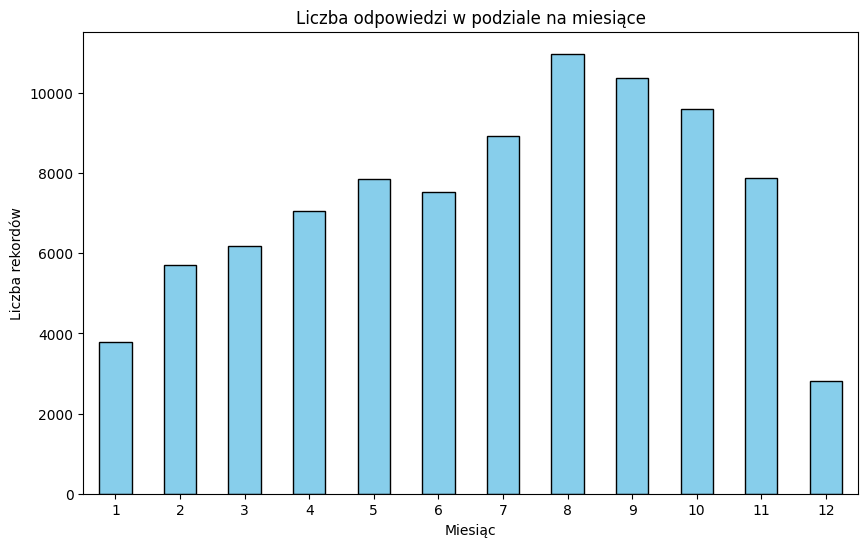

In [14]:
# Wyciągamy miesiąc i liczymy wystąpienia
monthly_data = df['Response Date'].dt.month.value_counts().sort_index()

# Wykres
plt.figure(figsize=(10, 6))
monthly_data.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Liczba odpowiedzi w podziale na miesiące')
plt.xlabel('Miesiąc')
plt.ylabel('Liczba rekordów')
plt.xticks(rotation=0)
plt.show()
#Zauważalnie w grudniu odpowiedzi było najmniej, to oczywiste ponieważ ostatnia ankieta wpadła 16 grudnia 2025

### 1.4 Obsługa braków danych wynikająca z braku danego pytania

In [15]:
#W zbiorze występują dwa typy braków danych: Nan oraz N/A, w zależności od zmiennej musimy inaczej je potraktować

# 1. Liczymy dosłowne teksty "N/A"
na_text_counts = (df == "N/A").sum()

# 2. Liczymy techniczne blanki (NaN / None)
blank_counts = df.isna().sum()

# 3. Łączymy to w jedną czytelną tabelę
missing_table = pd.DataFrame({
    'Tekstowe "N/A"': na_text_counts,
    'Techniczne Blanki': blank_counts
})
missing_table

,"Tekstowe ""N/A""",Techniczne Blanki
ID,0,0
Response Date,0,0
Delay - F1,0,1447
Delay - F2,0,53430
Range - F1,0,0
Range - F2,0,51215
Cabin Class - F1,0,0
Cabin Class - F2,0,51215
M&M Flag,0,0
Pax on PNR,0,0


In [16]:
# Kolumna Delay - F1, jeżeli brak danych to znaczy że samolot się nie spóźnił
df['Delay - F1'] = df['Delay - F1'].fillna(0)

In [17]:
#Zamiana Transfer Flag na binarą
df['Transfer Flag'] = df['Transfer Flag'].map({'Yes': 1, 'No': 0})
print(df['Transfer Flag'].value_counts())

Transfer Flag
0    51215
1    37492
Name: count, dtype: int64


In [18]:
# Zmienne Delay mają za dużo kategorii -  w tym celu łączę je w 3: nieopóźniony, lekko opóźniony i bardzo opóźniony
# Według standardów IATA i Eurocontrol, lot uznaje się za "punktualny", jeśli wystartuje lub wyląduje do 15 minut po planowanym czasie.
# Zakres do 1 godziny pozwala wyłonić loty, które mają problem operacyjny, ale mieszczą się w tzw. "buforze" czasowym większości lotnisk
# Przekroczenie 60 minut to w lotnictwie poważne zakłócenie. Granica > 180 min (3 godziny) jest szczególnie istotna w Unii Europejskiej 
# ze względu na rozporządzenie WE 261/2004, które od tego momentu często daje pasażerom prawo do odszkodowania pieniężnego.

delay_mapping = {
    # Nie opóźniony
    '0': 'Nie opóźniony',
    '1-15 min': 'Nie opóźniony',
    
    # Lekko opóźniony
    '16-30 min': 'Lekko opóźniony',
    '31-45 min': 'Lekko opóźniony',
    '46-60 min': 'Lekko opóźniony',
    
    # Bardzo opóźniony
    '61-120 min': 'Bardzo opóźniony',
    '121- 180 min': 'Bardzo opóźniony', # Uwaga: na obrazku widać spację po myślniku
    '> 180 min': 'Bardzo opóźniony'
}


cols_to_fix = ['Delay - F1', 'Delay - F2']

for col in cols_to_fix:
    # Opcjonalnie: .str.strip() usuwa ewentualne ukryte spacje na początku/końcu
    df[col] = df[col].str.strip().map(delay_mapping)

In [19]:
# Kolumna Delay - F1, jeżeli brak danych to znaczy że samolot się nie spóźnił
df.loc[(df['Delay - F1'].isna()), 'Delay - F1'] = 'Nie opóźniony'

In [20]:
#Kolumna Delay -F2, jeżeli brak danych a Transfer Flag 1 to samolot się nie spóźnił, w przeciwnym wypadku nie było 2 lotu i przypisz -999
df.loc[(df['Delay - F2'].isna()) & (df['Transfer Flag'] == 1), 'Delay - F2'] = 'Nie opóźniony'
df.loc[(df['Delay - F2'].isna()) & (df['Transfer Flag'] == 0), 'Delay - F2'] = -999

In [21]:
#Kolumny Range - F2 i Cabin Class - F2, przypisujemy -999 kiedy transfer flag = 0
df.loc[(df['Range - F2'].isna()) & (df['Transfer Flag'] == 0), 'Range - F2'] = -999
df.loc[(df['Cabin Class - F2'].isna()) & (df['Transfer Flag'] == 0), 'Cabin Class - F2'] = -999

In [22]:
#Kolumna M&M Flag nie ma braków, ale zamieniam ją na binarną
df['M&M Flag'] = df['M&M Flag'].map({'Yes': 1, 'No': 0})
print(df['M&M Flag'].value_counts())

M&M Flag
0    74980
1    13727
Name: count, dtype: int64


In [23]:
# Flagujemy grupy większe równe 4 osób, nie jest to oficjalna grupa, ponieważ taka zaczyna się od 10 pasażerów, jednak w danych chciałem wyłapać
# Czy podróżowanie w więcej osób wpływa na satysfakcję
df['Group Flag'] = df['Pax on PNR'].isin(['4', '5+']).astype(int)
# Usuwamy starą kolumnę
df = df.drop(columns='Pax on PNR')
# Sprawdzamy nowe statystyki
print(df['Group Flag'].value_counts())

Group Flag
0    84176
1     4531
Name: count, dtype: int64


In [24]:
# Kolumna Comment ma kilka tekstowych "N/A", zmieniam to na NaN
df['Comment'] = df['Comment'].replace('N/A', np.nan)
# Ta kolumna nie będzie użyta w modelu, ale posłuży do analizy sentymentu

In [25]:
#Kolumna Check-in jest popsuta, NaN nie powinny wystąpić, narazie zostawiam bez zmian, docelowo zmieniam N/A na NaN

In [26]:
#Kolumny Boarding, Security check, Gate experience - zmieniam N/A na NaN
cols_to_fix = ['Boarding', 'Security check', 'Gate experience']
for col in cols_to_fix:
    
    df[col] = pd.to_numeric(df[col], errors='coerce') # zmienienie na float samo przekonwertuje N/A na NaN

In [27]:
#Agregacja kolumn dotyczących business lounge, zakładam że ci którzy nie wypełnili ankiety nie mieli okazji skorzystać z Lounge
lounge_cols = ['Business Lounge at WAW (Warsaw)', 'Business Lounge at ORD (Chicago)']
for col in lounge_cols:
    
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Pandas obsłuży to tak: [5, NaN] -> 5.0 | [4, 6] -> 5.0 | [NaN, NaN] -> NaN
df['Business Lounge'] = df[lounge_cols].mean(axis=1)

df = df.drop(columns=lounge_cols)

# Wynik: 1 = Pax był w BL (jest ocena), 0 = Paxa nie było w BL (brak oceny)
df['BL Flag'] = df['Business Lounge'].notna().astype(int)

# Zastępujemy puste miejsca (NaN) wartością -999
df['Business Lounge'] = df['Business Lounge'].fillna(-999)

In [28]:
# Osoby, które nie miały transferu przypisuję -999, pozostali poprostu nie odpowiedzieli
df.loc[(df['Transfer Flag'] == 0), 'Transfer'] = -999
# W następnej kolejności zmieniam N/A na nan i konwertuje na float
df['Transfer'] = pd.to_numeric(df['Transfer'], errors='coerce')

In [29]:
#Zmienna Baggage Claim - bardzo dużo braków, ze względu na to że wielu pasażerów nie nadaje bagażu, niestety z danych nie wynika, którzy pasażerowie
# nie nadawali a którzy nie odpowiedzieli przypisuje wiec wszystkim brakom -999
df['Baggage claim'] = pd.to_numeric(df['Baggage claim'], errors='coerce')
# Tworzenie flagi
# Wynik: 1 = Bagaż był (jest ocena), 0 = Brak bagażu (brak oceny)
df['Baggage Flag'] = df['Baggage claim'].notna().astype(int)
#Przypisuję -999
df.loc[df['Baggage claim'].isna(), 'Baggage claim'] = -999

In [30]:
#Zamiana IFE Flags na binarną
df['IFE Flag - F1'] = df['IFE Flag - F1'].map({'Yes': 1, 'No': 0})
print(df['IFE Flag - F1'].value_counts())
df['IFE Flag - F2'] = df['IFE Flag - F2'].map({'Yes': 1, 'No': 0})
print(df['IFE Flag - F2'].value_counts())

IFE Flag - F1
0    77150
1    11557
Name: count, dtype: int64
IFE Flag - F2
0    83307
1     5400
Name: count, dtype: int64


In [31]:
# Zmienne dotyczące IFE, jeżeli pax nie miał dostępu (flaga 0) to przypisz -999
df.loc[df['IFE Flag - F1'] == 0, 'IFE - F1'] = -999
df['IFE - F1'] = pd.to_numeric(df['IFE - F1'], errors='coerce')
df.loc[df['IFE Flag - F2'] == 0, 'IFE - F2'] = -999
df['IFE - F2'] = pd.to_numeric(df['IFE - F2'], errors='coerce')

In [32]:
print(df['Accessories - F1'].value_counts())

Accessories - F1
5      1907
4       605
3       199
N/A      54
2        50
1        39
Name: count, dtype: int64


In [33]:
#Zajmujemy siękolumną dotyczącą akcesoriów, mamy bardzo dużo braków, wynika to głównie z faktu że tylko Premium i Biznes dostają te rzeczy
import pandas as pd
import numpy as np

analysis_df = df.copy()

# pomocnicze kolumny logizzne
analysis_df['Is_Blank'] = analysis_df['Accessories - F1'].isna()
analysis_df['Is_NA_Text'] = analysis_df['Accessories - F1'] == 'N/A'
analysis_df['Has_Rating'] = pd.to_numeric(analysis_df['Accessories - F1'], errors='coerce').notna()

# Tabelka z missingami
missing_report = analysis_df.groupby('Cabin Class - F1').agg({
    'Is_Blank': 'sum',      # Suma fizycznych pustych pól
    'Is_NA_Text': 'sum',    # Suma wpisów tekstowych "N/A"
    'Has_Rating': 'sum'     # Ile osób wystawiło ocenę
})

# % Udział ocen
missing_report['Completeness_%'] = (missing_report['Has_Rating'] / 
                                    (missing_report['Is_Blank'] + missing_report['Is_NA_Text'] + missing_report['Has_Rating']) * 100).round(2)

print(missing_report)
#podsumowując potwierdziło się że economy tego nie dostaje, więc przypisuję im -999, premium ma wysoki poziom 

                  Is_Blank  Is_NA_Text  Has_Rating  Completeness_%
Cabin Class - F1                                                  
C                     3152          22        1266           28.51
P                      100          32        1534           92.08
Y                    82601           0           0            0.00


In [34]:
# Sprawdzamy hipotezę: Akcesoria = Klasa (C/P) + Zasięg (LH)
range_check = df.groupby(['Cabin Class - F1', 'Range - F1']).agg({
    'Accessories - F1': lambda x: pd.to_numeric(x, errors='coerce').notna().mean() * 100
}).round(2)

range_check.columns = ['% wypełnionych ocen']
print("Procent wystawionych ocen w zależności od klasy i zasięgu:")
print(range_check)
#To pokazuje nam że akcesoria dostaje się jedynie na LH nie w economy

Procent wystawionych ocen w zależności od klasy i zasięgu:
                             % wypełnionych ocen
Cabin Class - F1 Range - F1                     
C                DOM                        0.00
                 LH                        97.53
                 SH                         0.00
P                LH                        97.40
                 SH                         0.00
Y                DOM                        0.00
                 LH                         0.00
                 SH                         0.00


In [35]:
# Lista par kolumn do przetworzenia
flights = [
    {'score': 'Accessories - F1', 'class': 'Cabin Class - F1', 'range': 'Range - F1'},
    {'score': 'Accessories - F2', 'class': 'Cabin Class - F2', 'range': 'Range - F2'}
]

for f in flights:
    #  Konwersja na liczby
    df[f['score']] = pd.to_numeric(df[f['score']], errors='coerce')
    
    # Definicja braku usługi:
    # True = Usługa NIE przysługiwała (Strukturalny brak)
    mask_no_service = (df[f['range']] != 'LH') | (df[f['class']] == 'Y')

    # TWORZENIE FLAGI "Brak ..."
    flag_name =  f['score'] + ' Flag'
    
    # Przypisanie: 1 jeśli usługi brakowało, 0 jeśli przysługiwała
    df[flag_name] = (~mask_no_service).astype(int)

    # 4. Przypisanie -999
    df.loc[mask_no_service, f['score']] = -999

In [36]:
#Pozbywamy się N/A dla kolumn F1 i przekszatałcamy na numeric te pytania (oprócz IFE i Akcesoriów, ale to jest obsługiwane osobno)
# z założenia dostali wszyscy pasażerowie
cols_f1 = [col for col in df.columns if 'F1' in col]
#tych nie chce zmieniać
exceptions = ['Delay - F1', 'Range - F1', 'IFE Flag - F1','Cabin Class - F1']

cols_to_convert = [col for col in cols_f1 if col not in exceptions]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [37]:
#Dla F2 bedzie podobnie, jednak najpierw trzeba oznaczyć te rekordy które mają Transfer Flag 0 przypisując -999
cols_f2 = [col for col in df.columns if 'F2' in col]

exceptions_f2 = ['Delay - F2', 'Range - F2', 'IFE Flag - F2','Cabin Class - F2','Accessories - F2 Flag']

cols_to_convert_f2 = [col for col in cols_f2 if col not in exceptions_f2]

#  paxbez transferu (Flag 0) otrzymują -999
for col in cols_to_convert_f2:
    df.loc[df['Transfer Flag'] == 0, col] = -999

#Pozostali pasażerowie mieli transfer, czyli nie odpowiedzieli poprostu na pytania, w takim przypadku oznaczamy ich jako blank poprzez konwersje typu
# konwersja na numeric
for col in cols_to_convert_f2:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [38]:
#Jeżeli mamy blank w wieku to oznaczam jako nie chcę podawać
df.loc[df['Age'].isna(), 'Age'] = "I prefer not to say" 

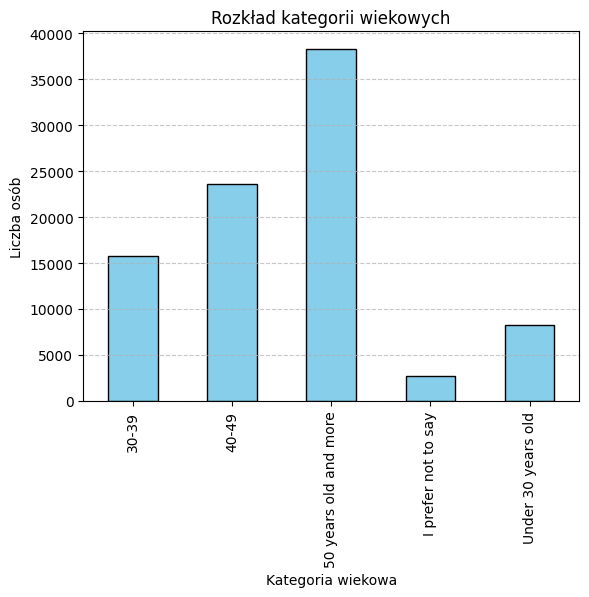

In [39]:
df['Age'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Rozkład kategorii wiekowych')
plt.xlabel('Kategoria wiekowa')
plt.ylabel('Liczba osób')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Dodaje pomocnicze linie poziome

plt.show()

In [40]:
print(df['Airline Travel Frequency'].value_counts(dropna=False, normalize=True))

Airline Travel Frequency
Once, several times a year         0.506499
This was my first trip with LOT    0.401344
At least once a month              0.079430
NaN                                0.012727
Name: proportion, dtype: float64


In [41]:
#NaN jest około 1.2% w całości, nie wiem co kryje się pod tymi brakami, ale mogą one nieść za sobą istotną informację, 
# z tego powodu tworzę nową kategorię
col_cat = 'Airline Travel Frequency'
# Wypełniamy w obu zbiorach
df[col_cat] = df[col_cat].fillna('Unknown')

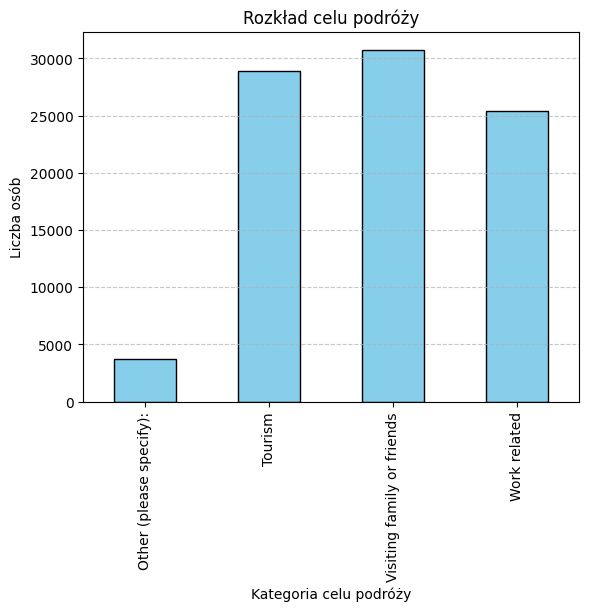

In [42]:
df['Purpose of trip'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Rozkład celu podróży')
plt.xlabel('Kategoria celu podróży')
plt.ylabel('Liczba osób')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Dodaje pomocnicze linie poziome

plt.show()

In [43]:
### Sprawdzam czy pozbyłem się wszystkich N/A

number_counts = (df == -999).sum()

na_text_counts = (df == "N/A").sum()

blank_counts = df.isna().sum()

missing_table = pd.DataFrame({
    'Tekstowe "N/A"': na_text_counts,
    '-999"': number_counts,
    'Prawdziwe braki': blank_counts
})
missing_table

,"Tekstowe ""N/A""","-999""",Prawdziwe braki
ID,0,0,0
Response Date,0,0,0
Delay - F1,0,0,0
Delay - F2,0,51215,0
Range - F1,0,0,0
Range - F2,0,51215,0
Cabin Class - F1,0,0,0
Cabin Class - F2,0,51215,0
M&M Flag,0,0,0
Country,0,0,0


### 1.5 Sprawdzenie typów braków

In [44]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr


# Lista zmiennych
Cols = [
    'Boarding', 'Security check', 'Gate experience', 'Transfer', 'Baggage claim', 'Business Lounge',
    'Punctuality - F1', 'Cabin crew service - F1', 'Food & Beverage - F1', 'IFE - F1', 
    'Cleanliness - F1', 'Your seat - F1', 'Leg room - F1', 
    'Space for hand luggage - F1', 'Temperature of the cabin - F1', 'Accessories - F1',
    'Punctuality - F2', 'Cabin crew service - F2', 'Food & Beverage - F2', 'Cleanliness - F2', 
    'IFE - F2', 'Your seat - F2', 'Leg room - F2', 
    'Space for hand luggage - F2', 'Temperature of the cabin - F2', 'Accessories - F2',
    'Purpose of trip', 'Airline Travel Frequency'
]

def analyze_mar_mechanism_filtered(df, Cols):
    results = []
    
    # Wybieram tylko numeryczne kolumny
    cols_num = [col for col in Cols if col in df.select_dtypes(include=[np.number]).columns]

    # Wybieram tylko te zmienne które mają braki
    cols_with_missing = [col for col in Cols if df[col].isnull().sum() > 0]
    
    if not cols_with_missing:
        return "Brak braków danych w wybranych zmiennych."

    for missing_col in cols_with_missing:
        missing_flag = df[missing_col].isnull().astype(int)
        
        for x in cols_num:
            if x == missing_col:
                continue
            
            
            # Korelacja
            valid_mask = df[x].notnull()
            if valid_mask.sum() < 2: continue

            corr, p_val = pointbiserialr(missing_flag[valid_mask], df.loc[valid_mask, x])
            
            # Tylko istotne korelacje
            if p_val < 0.05:
                results.append({
                    'Brak w zmiennej': missing_col,
                    'Koreluje z oceną': x,
                    'Korelacja': round(corr, 4),
                    'p-value': round(p_val, 4)
                })

    results_df = pd.DataFrame(results)
    if not results_df.empty:
        return results_df.sort_values(by='Korelacja', key=abs, ascending=False)
    else:
        return "Nie znaleziono istotnych korelacji po wykluczeniu flag."

raport_mar = analyze_mar_mechanism_filtered(df, Cols)
print(raport_mar)

          Brak w zmiennej               Koreluje z oceną  Korelacja  p-value
171              IFE - F1               Accessories - F1     0.2305   0.0000
422              IFE - F2               Accessories - F2     0.1963   0.0000
358  Food & Beverage - F2                       Transfer     0.1718   0.0000
378  Food & Beverage - F2  Temperature of the cabin - F2     0.1468   0.0000
375  Food & Beverage - F2                 Your seat - F2     0.1467   0.0000
..                    ...                            ...        ...      ...
300      Accessories - F1        Cabin crew service - F2    -0.0072   0.0330
302      Accessories - F1               Cleanliness - F2    -0.0072   0.0332
443        Your seat - F2                       IFE - F2    -0.0071   0.0337
403      Cleanliness - F2               Accessories - F2    -0.0069   0.0407
294      Accessories - F1                       Transfer    -0.0067   0.0456

[535 rows x 4 columns]


In [45]:

zmienne_z_brakami = [col for col in Cols if df[col].isnull().sum() > 0]

# (Wyciągamy unikalne nazwy z kolumny 'Brak w zmiennej')
zmienne_wyjasnione = raport_mar['Brak w zmiennej'].unique().tolist()

niewyjasnione = set(zmienne_z_brakami) - set(zmienne_wyjasnione)

print(f"Liczba zmiennych z brakami: {len(zmienne_z_brakami)}")
print(f"Liczba zmiennych, których braki były skorelowane z wartościami innych zmiennych: {len(zmienne_wyjasnione)}")
print(niewyjasnione)


Liczba zmiennych z brakami: 24
Liczba zmiennych, których braki były skorelowane z wartościami innych zmiennych: 24
set()


In [46]:
# Etap 1: Izolacja braków strukturalnych (Structural Missingness)
# Braki wynikające z fizycznej niedostępności usługi (potwierdzone flagami, np. brak posiłku)
# zostały zakodowane wartością stałą -999. Nie podlegają one imputacji, gdyż stanowią
# osobną kategorię informacyjną dla modelu (usługa nie wystąpiła).

# Etap 2: Weryfikacja mechanizmu dla pozostałych braków (Rzeczywiste braki danych)
# Przeprowadzona analiza korelacji dla zmiennych, gdzie usługa była dostępna,
# ale nie została oceniona, wykazała następujące fakty:

# 1. Kompletność wyjaśnienia (100% pokrycia):
#    Każda zmienna zawierająca braki danych wykazuje przynajmniej jedną istotną statystycznie
#    korelację (p-value < 0.05) z inną zmienną obserwowalną w zbiorze (oceną innej usługi).

# 2. Potwierdzenie mechanizmu MAR (Missing At Random):
#    Istnienie statystycznych "wyjaśniaczy" dla wszystkich zmiennych z brakami pozwala odrzucić
#    hipotezę o całkowitej losowości (MCAR). Zależność braku odpowiedzi od innych ocen
#    satysfakcji (np. powiązanie oceny IFE z Akcesoriami) wskazuje na mechanizm MAR.

### 1.6 Imputacja "prawdziwych" braków

In [47]:
"""
Imputacja:

Kontekst:
Zbiór zawiera dwa rodzaje braków:
1. Prawdziwe braki danych (NaN).
2. Sztuczne braki oznaczone jako -999 (posiadające osobne flagi binarne) wynikające z braku pytania.

Docelowo chcę
a) Imputować braki NaN
b) Sprawić aby -999 było niewidoczne dla analizy SHAP

Uzasadnienie kolejności działań:

KROK 1: Imputacja kNN na "czystych" danych
Najpierw zamieniam -999 na NaN i uruchamiamy kNN na całości.
Dzięki temu algorytm kNN szuka sąsiadów wyłącznie w oparciu o obserwowane dane.
Gdybyśmy najpierw zastąpili -999 średnią, wprowadzilibyśmy obciążenie,
który zaburzyłby metrykę odległości euklidesowej i pogorszył jakość uzupełniania 
prawdziwych braków (NaN).

KROK 2: Nadpisanie miejsc po -999 Globalną Średnią
Po zakończeniu imputacji, w miejscach gdzie pierwotnie było -999,
nadpisujemy wynik kNN globalną średnią ze zbioru treningowego.
Cel: "Wygaszenie" tych rekordów dla modelu i analizy SHAP.
Dla sieci neuronowej średnia jest wartością neutralną (bliską zeru po skalowaniu).
Powoduje to, że w analizie ważności cech (SHAP) te konkretne przypadki nie generują 
siły predykcyjnej (są "przezroczyste"), a informacja o ich specyfice jest czerpana 
wyłącznie z dedykowanych kolumn flag (binary indicators).
"""

'\nImputacja:\n\nKontekst:\nZbiór zawiera dwa rodzaje braków:\n1. Prawdziwe braki danych (NaN).\n2. Sztuczne braki oznaczone jako -999 (posiadające osobne flagi binarne) wynikające z braku pytania.\n\nDocelowo chcę\na) Imputować braki NaN\nb) Sprawić aby -999 było niewidoczne dla analizy SHAP\n\nUzasadnienie kolejności działań:\n\nKROK 1: Imputacja kNN na "czystych" danych\nNajpierw zamieniam -999 na NaN i uruchamiamy kNN na całości.\nDzięki temu algorytm kNN szuka sąsiadów wyłącznie w oparciu o obserwowane dane.\nGdybyśmy najpierw zastąpili -999 średnią, wprowadzilibyśmy obciążenie,\nktóry zaburzyłby metrykę odległości euklidesowej i pogorszył jakość uzupełniania \nprawdziwych braków (NaN).\n\nKROK 2: Nadpisanie miejsc po -999 Globalną Średnią\nPo zakończeniu imputacji, w miejscach gdzie pierwotnie było -999,\nnadpisujemy wynik kNN globalną średnią ze zbioru treningowego.\nCel: "Wygaszenie" tych rekordów dla modelu i analizy SHAP.\nDla sieci neuronowej średnia jest wartością neutralną

In [48]:
#Krok 1
# Używamy kNN na wszystkich brakach (NaN i -999 zamienione na NaN),
# aby metryka odległości nie była zaburzona przez sztuczną średnią.

In [49]:
# Lista zmiennych objaśniających (X)
selected_features = [
    # Twarde dane o lotach/pasażerze 
    'Range - F1', 'Range - F2', 'Cabin Class - F1', 'Cabin Class - F2', 'Delay - F1', 'Delay - F2',
    # Flagi
    'M&M Flag', 'Transfer Flag', 'IFE Flag - F1', 'IFE Flag - F2', 
    'Group Flag', 'Baggage Flag', 'Accessories - F1 Flag', 'Accessories - F2 Flag', 'BL Flag',
    # Usługi ogólne
    'Boarding', 'Security check', 'Gate experience', 'Transfer', 'Baggage claim', 'Business Lounge',
    # Lot 1
    'Punctuality - F1', 'Cabin crew service - F1', 'Food & Beverage - F1', 'IFE - F1', 
    'Cleanliness - F1', 'Your seat - F1', 'Leg room - F1', 
    'Space for hand luggage - F1', 'Temperature of the cabin - F1', 'Accessories - F1',
    # Lot 2
    'Punctuality - F2', 'Cabin crew service - F2', 'Food & Beverage - F2', 'Cleanliness - F2', 
    'IFE - F2', 'Your seat - F2', 'Leg room - F2', 
    'Space for hand luggage - F2', 'Temperature of the cabin - F2', 'Accessories - F2',
    # Pozostałe
    'Purpose of trip', 'Airline Travel Frequency'
]
# NPS to zmienna celu
target_col = 'NPS'

X = df[selected_features].copy()
y = df[target_col].copy()

In [50]:
# Aby zastosować metodę kNN, gdzie algorytm musi porównać ich cechy muszę zamienić wszystkie zmienne do typu numerycznego, nawet kategorialne
# po to aby służyły jako punkt odniesienia do imputowania zmiennych numerycznych
cat_cols_to_encode = [
    'Range - F1', 'Range - F2', 
    'Cabin Class - F1', 'Cabin Class - F2', 
    'Purpose of trip', 'Airline Travel Frequency',
    'Delay - F1', 'Delay - F2'
]
#konwertuję kolumny kategorialne na string (występują w nich wartości -999 i to wyrzucało błąd)
X[cat_cols_to_encode] = X[cat_cols_to_encode].astype(str)

# pod encoder posłuży nam później do odkodowania tych zmiennych
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Kodujemy w obu zbiorach (zamiana napisów na liczby 0, 1, 2...)
X[cat_cols_to_encode] = encoder.fit_transform(X[cat_cols_to_encode])



In [51]:
#Teraz dzielę na zbiory treningowy, walidacyjny i testowy w proporcji Train (70%) / Val (15%) / Test (15%)
# WYdzielam testowy
X_work, X_test, y_work, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Wydzielam walidacyjny
# 0.15 / 0.85 = ~0.1765
val_size_adjusted = 0.15 / 0.85 

X_train, X_val, y_train, y_val = train_test_split(
    X_work, y_work, test_size=val_size_adjusted, random_state=42, stratify=y_work
)


print(f"Rozmiar Train: {X_train.shape[0]}")
print(f"Rozmiar Train: {X_val.shape[0]}")
print(f"Rozmiar Train: {X_test.shape[0]}")

Rozmiar Train: 62094
Rozmiar Train: 13306
Rozmiar Train: 13307


In [52]:
#Zdecydowałem się pozostawić wartości ciągłe generowane przez k-NN, ponieważ ich zaokrąglanie do mediany wiązałoby się z utratą informacji,
#nie wnosząc jednocześnie żadnej wartości dodanej z perspektywy głównego celu pracy.
#W kontekście identyfikacji czynników wpływających na niezadowolenie (analiza SHAP) 
# model i tak prawidłowo zinterpretuje wagę danej cechy, dlatego uznałem dodatkowe przekształcenia za zbędne.

In [53]:
#Funkcja służąca do imputacji
def holistic_knn_imputation(X_train, X_val, X_test, target_cols_to_impute, k_neighbors=5):
    """
    Wykonuje imputację kNN na całym zbiorze danych (wykorzystując wszystkie zmienne do szukania sąsiadów),
    ale 'naprawia' i maskuje tylko wskazane kolumny (target_cols_to_impute).
    """
    
    train_filled = X_train.copy()
    val_filled = X_val.copy()
    test_filled = X_test.copy()
    
    all_columns = X_train.columns
    
    # MASKOWANIE -999
    # Zapamiętujemy gdzie jest -999 tylko w kolumnach ankietowych (tam gdzie chcemy je przywrócić)
    # I zamieniamy je na NaN, żeby imputer je widział jako brak do uzupełnienia.
    
    print("Tworzenie masek i 'tymczasowa amnezja' dla -999...")
    masks = {}
    
    for name, df in [('train', train_filled), ('val', val_filled), ('test', test_filled)]:
        # true w tych komórkach które zawierają -999
        masks[name] = df[target_cols_to_impute] == -999
        
        # Zamiana -999 na NaN 
        df[target_cols_to_impute] = df[target_cols_to_impute].replace(-999, np.nan)

    # IMPUTACJA
    print(f"Trenowanie KNNImputer (k={k_neighbors}) na całym zbiorze treningowym")
    
    imputer = KNNImputer(n_neighbors=k_neighbors)
    
    # Uczenie na całym treningowym zbiorze
    imputer.fit(train_filled)
    
    print("Aplikowanie imputacji (u mnie zajęło to około 12 minut)...")
    
    # Funkcja pomocnicza do transformacji i odzyskania DataFrame (imputer zwraca surową macierz numpy)
    def transform_and_rebuild(imputer_instance, df_input):
        # Transformacja
        matrix_imputed = imputer_instance.transform(df_input)
        # Odtworzenie df z indeksami i nazwami kolumn
        return pd.DataFrame(matrix_imputed, columns=all_columns, index=df_input.index)

    # Transformujemy każdy zbiór
    train_filled = transform_and_rebuild(imputer, train_filled)
    val_filled   = transform_and_rebuild(imputer, val_filled)
    test_filled  = transform_and_rebuild(imputer, test_filled)

    # Przywracanie -999 za pomocą poprzednio stworzonej maski
    print("Przywracanie wartości -999 ...")
    
    # Przywracamy -999 tylko tam, gdzie były wcześniej
    train_filled[target_cols_to_impute] = train_filled[target_cols_to_impute].mask(masks['train'], -999)
    val_filled[target_cols_to_impute]   = val_filled[target_cols_to_impute].mask(masks['val'], -999)
    test_filled[target_cols_to_impute]  = test_filled[target_cols_to_impute].mask(masks['test'], -999)
    
    print("Zakńczono proces imputacji braków")
    return train_filled, val_filled, test_filled

In [54]:
# Automatyczne wykrycie kolumn, które mają przynajmniej jeden NaN - wiem że nasze zmienne kategorialne nie mają już
# żadnych braków NaN (jedynie -999 a tych poniższy kod nie flaguje jako zmienne z brakami), dlatego imputowane powinny być
# jedynie zmienne numeryczne, bierzemy też te które mają jakąkolwiek wartośc -999 bo inaczej w procesie imputacji wzięłoby tą wartość do obliczania
cols_to_impute = [
    col for col in X_train.columns 
    if X_train[col].isna().any() or (X_train[col] == -999).any()
]

print(f"Liczba kolumn do imputacji: {len(cols_to_impute)}")
print("Lista kolumn do imputacji:")
print(cols_to_impute)

Liczba kolumn do imputacji: 26
Lista kolumn do imputacji:
['Boarding', 'Security check', 'Gate experience', 'Transfer', 'Baggage claim', 'Business Lounge', 'Punctuality - F1', 'Cabin crew service - F1', 'Food & Beverage - F1', 'IFE - F1', 'Cleanliness - F1', 'Your seat - F1', 'Leg room - F1', 'Space for hand luggage - F1', 'Temperature of the cabin - F1', 'Accessories - F1', 'Punctuality - F2', 'Cabin crew service - F2', 'Food & Beverage - F2', 'Cleanliness - F2', 'IFE - F2', 'Your seat - F2', 'Leg room - F2', 'Space for hand luggage - F2', 'Temperature of the cabin - F2', 'Accessories - F2']


In [55]:
# Wywołanie funkcji imputacyjnej (może długo potrwać)
X_train_filled, X_val_filled, X_test_filled = holistic_knn_imputation(
    X_train, X_val, X_test, 
    target_cols_to_impute=cols_to_impute,
    k_neighbors=5
)

Tworzenie masek i 'tymczasowa amnezja' dla -999...
Trenowanie KNNImputer (k=5) na całym zbiorze treningowym
Aplikowanie imputacji (u mnie zajęło to około 12 minut)...
Przywracanie wartości -999 ...
Zakńczono proces imputacji braków


In [56]:
print(f"Rozmiar Train: {X_train_filled.shape[0]}")
print(f"Rozmiar Train: {X_val_filled.shape[0]}")
print(f"Rozmiar Train: {X_test_filled.shape[0]}")

Rozmiar Train: 62094
Rozmiar Train: 13306
Rozmiar Train: 13307


In [57]:
# Sprawdzam czy imputacja NaN się powiodła

blank_counts_train = X_train_filled.isna().sum()
blank_counts_val = X_val_filled.isna().sum()
blank_counts_test = X_test_filled.isna().sum()

missing_table = pd.DataFrame({
    'Tree Train': blank_counts_train,
    'Tree Val':   blank_counts_val,
    'Tree Test':  blank_counts_test

})

missing_table

,Tree Train,Tree Val,Tree Test
Range - F1,0,0,0
Range - F2,0,0,0
Cabin Class - F1,0,0,0
Cabin Class - F2,0,0,0
Delay - F1,0,0,0
Delay - F2,0,0,0
M&M Flag,0,0,0
Transfer Flag,0,0,0
IFE Flag - F1,0,0,0
IFE Flag - F2,0,0,0


In [58]:
# Krok 2
# Dla miejsc, gdzie było -999, wyliczamy ŚREDNIĄ (a nie wynik kNN).
# Dzięki temu w analizie SHAP te wartości będą neutralne ("niewidoczne"),
# a model skupi się na flagach binarnych, zamiast na zaszumionych wartościach.

In [59]:
#Funkcja która wylicza średnią dla danej zmiennej numerycznej zamiast wartości -999, ale tylko na zbiorze treningowym,
# aby nie dopuścić do data leakage

def neutralize_missing_codes(train_df, val_df, test_df, missing_code=-999):
    """
    Zastępuje wartość 'missing_code' (-999) średnią wyliczoną 
    tylko na zbiorze treningowym (z wyłączeniem tej wartości z obliczeń).
    """
    
    df_train_neutral = train_df.copy()
    df_val_neutral = val_df.copy()
    df_test_neutral = test_df.copy()
    
    # Pobieramy listę kolumn numerycznych (akurat wszystkie są numeryczne na tym etapie, ale w razie czego)
    numeric_cols = df_train_neutral.select_dtypes(include=[np.number]).columns
    
    print(f"Rozpoczynam neutralizację kodu {missing_code} średnią globalną...")
    
    count_modified = 0
    
    for col in numeric_cols:
        # Sprawdzam zy w ogóle w tej kolumnie (w treningu) występuje -999?
        # Sprawdzam też w val/test, bo może się zdarzyć, że w train nie ma, a w test jest (rzadkie, ale możliwe)
        # jeśli nie ma -999 to szkoda czasu
        has_code_train = (df_train_neutral[col] == missing_code).any()
        has_code_val   = (df_val_neutral[col] == missing_code).any()
        has_code_test  = (df_test_neutral[col] == missing_code).any()
        
        if has_code_train or has_code_val or has_code_test:
            
            # Wyliczenie średniej
            # Liczymy średnią tylko na zbiorze treningowym.
            # Musimy wykluczyć z obliczeń:
            #  a) Same wartości -999 (bo zaniżyłyby średnią drastycznie)
            #  b) Prawdziwe NaN (jeśli jakieś się ostały, ale wiem że u mnie nie)
            
            valid_values = df_train_neutral.loc[df_train_neutral[col] != missing_code, col]
            global_mean = valid_values.mean()
            
            # Nadpisywanie średnią z treningu na wszystkich zbiorach
            
            if has_code_train:
                df_train_neutral[col] = df_train_neutral[col].replace(missing_code, global_mean)
            
            if has_code_val:
                df_val_neutral[col] = df_val_neutral[col].replace(missing_code, global_mean)
                
            if has_code_test:
                df_test_neutral[col] = df_test_neutral[col].replace(missing_code, global_mean)
            
            count_modified += 1

    print(f"Zmodyfikowano łącznie {count_modified} kolumn.")
    return df_train_neutral, df_val_neutral, df_test_neutral

In [60]:
# Odpalenie powyższej funkcji
X_train_mean, X_val_mean, X_test_mean = neutralize_missing_codes(X_train_filled, X_val_filled, X_test_filled)

Rozpoczynam neutralizację kodu -999 średnią globalną...
Zmodyfikowano łącznie 15 kolumn.


### 1.7 One hot encoding

In [61]:
# Pozbyliśmy się braków z sukcesem, jednak OrdinalEncoder zmienił nam kategorie na liczby, co było potrzebne do kNN, ale teraz jest trochę mylące
# encoder jednak zapamiętał mapowanie
# Sprawdzamy, co oznaczają liczby w kolumnach kategorialnych
# encoder.categories_ to lista, gdzie każda lista odpowiada jednej kolumnie

encoded_columns = [
    'Range - F1', 'Range - F2', 
    'Cabin Class - F1', 'Cabin Class - F2', 
    'Purpose of trip', 'Airline Travel Frequency',
    'Delay - F1', 'Delay - F2'
]

for i, col_name in enumerate(encoded_columns):

    original_names = encoder.categories_[i]
    
    print(f"Zmienna: {col_name}")
    for value, name in enumerate(original_names):
        # value to 0, 1, 2... (to co widzi model)
        # name to "Economy", "Business" itd
        print(f"  {float(value)} = '{name}'")
    print("-" * 30)

Zmienna: Range - F1
  0.0 = 'DOM'
  1.0 = 'LH'
  2.0 = 'SH'
------------------------------
Zmienna: Range - F2
  0.0 = '-999'
  1.0 = 'DOM'
  2.0 = 'LH'
  3.0 = 'SH'
------------------------------
Zmienna: Cabin Class - F1
  0.0 = 'C'
  1.0 = 'P'
  2.0 = 'Y'
------------------------------
Zmienna: Cabin Class - F2
  0.0 = '-999'
  1.0 = 'C'
  2.0 = 'P'
  3.0 = 'Y'
------------------------------
Zmienna: Purpose of trip
  0.0 = 'Other (please specify):'
  1.0 = 'Tourism'
  2.0 = 'Visiting family or friends'
  3.0 = 'Work related'
------------------------------
Zmienna: Airline Travel Frequency
  0.0 = 'At least once a month'
  1.0 = 'Once, several times a year'
  2.0 = 'This was my first trip with LOT'
  3.0 = 'Unknown'
------------------------------
Zmienna: Delay - F1
  0.0 = 'Bardzo opóźniony'
  1.0 = 'Lekko opóźniony'
  2.0 = 'Nie opóźniony'
------------------------------
Zmienna: Delay - F2
  0.0 = '-999'
  1.0 = 'Bardzo opóźniony'
  2.0 = 'Lekko opóźniony'
  3.0 = 'Nie opóźniony'


In [62]:
encoded_columns = [
    'Range - F1', 'Range - F2', 
    'Cabin Class - F1', 'Cabin Class - F2', 
    'Purpose of trip', 'Airline Travel Frequency',
    'Delay - F1', 'Delay - F2' 
]

# Funckcja która przetworzy tak każdy zbiór
def process_encoding(df_input, encoder, columns_list):
    
    df = df_input.copy()

    # Przywracanie nazw
    for i, col_name in enumerate(columns_list):
        if col_name not in df.columns:
            continue # Pomijamy, jeśli kolumny nie ma
            
        # Pobieram kategorie z encodera
        categories = encoder.categories_[i]
        
        # mapowanie
        mapping_dict = {}
        for index, label in enumerate(categories):
            label_str = str(label)
            
            # Zamieniam kategorie -999 na No_Flight - jeżeli wykryje -999 to zamień na No_Flight
            if '-999' in label_str: 
                new_label = 'No_Flight'
                
            # Zamiana "LOT" na "airline"
            elif 'This was my first trip with LOT' in label_str:
                new_label = label_str.replace('LOT', 'airline')
                
            else:
                new_label = label_str
                
            mapping_dict[index] = new_label
            
        # Aplikujemy mapowanie
        df[col_name] = df[col_name].map(mapping_dict)

    # One hot encoding
    df_encoded = pd.get_dummies(df, columns=columns_list, prefix=columns_list, drop_first=False)
    
    # Usuwanie dummies z No_flight w nazwie - brak drugiego lotu jest już flagowany w kolumnie Transfer Flag
    cols_to_drop = [c for c in df_encoded.columns if 'F2' in c and 'No_Flight' in c]
    
    if cols_to_drop:
        print(f"Usuwam nadmiarowe kolumny: {cols_to_drop}")
        df_encoded = df_encoded.drop(columns=cols_to_drop)
    
    return df_encoded

# teraz odpalam funkcje na każdym zbiorze

X_train_final = process_encoding(X_train_mean, encoder, encoded_columns)
X_val_final   = process_encoding(X_val_mean, encoder, encoded_columns)
X_test_final  = process_encoding(X_test_mean, encoder, encoded_columns)


# Sprawdzam czy liczba kolumn się zgadza we wszystkich zbiorach
print(f"Tree Train: {X_train_final.shape}")
print(f"Tree Val:   {X_val_final.shape}")
print(f"Tree Test:  {X_test_final.shape}")

# Ostateczne sprawdzenie
bad_cols = [c for c in X_train_final.columns if 'Delay - F2_No_Flight' in c]
if not bad_cols:
    print("Sukces: Usunięto nadmiarowe kolumny 'No_Flight' dla F2.")
else:
    print(f"BŁĄD: Nadal istnieją kolumny: {bad_cols}")

Usuwam nadmiarowe kolumny: ['Range - F2_No_Flight', 'Cabin Class - F2_No_Flight', 'Delay - F2_No_Flight']
Usuwam nadmiarowe kolumny: ['Range - F2_No_Flight', 'Cabin Class - F2_No_Flight', 'Delay - F2_No_Flight']
Usuwam nadmiarowe kolumny: ['Range - F2_No_Flight', 'Cabin Class - F2_No_Flight', 'Delay - F2_No_Flight']
Tree Train: (62094, 61)
Tree Val:   (13306, 61)
Tree Test:  (13307, 61)
Sukces: Usunięto nadmiarowe kolumny 'No_Flight' dla F2.


In [63]:
# Sprawdzam czy One Hot encoding się udał
X_train_final['Delay - F1_Lekko opóźniony'].value_counts()

Delay - F1_Lekko opóźniony
False    52046
True     10048
Name: count, dtype: int64

### 1.8 Korelacja - usuwanie zmiennych ze sobą skorelowanych

In [64]:
#Wyliczenia korelacji na treningowym, sklejam czasowo z NPS

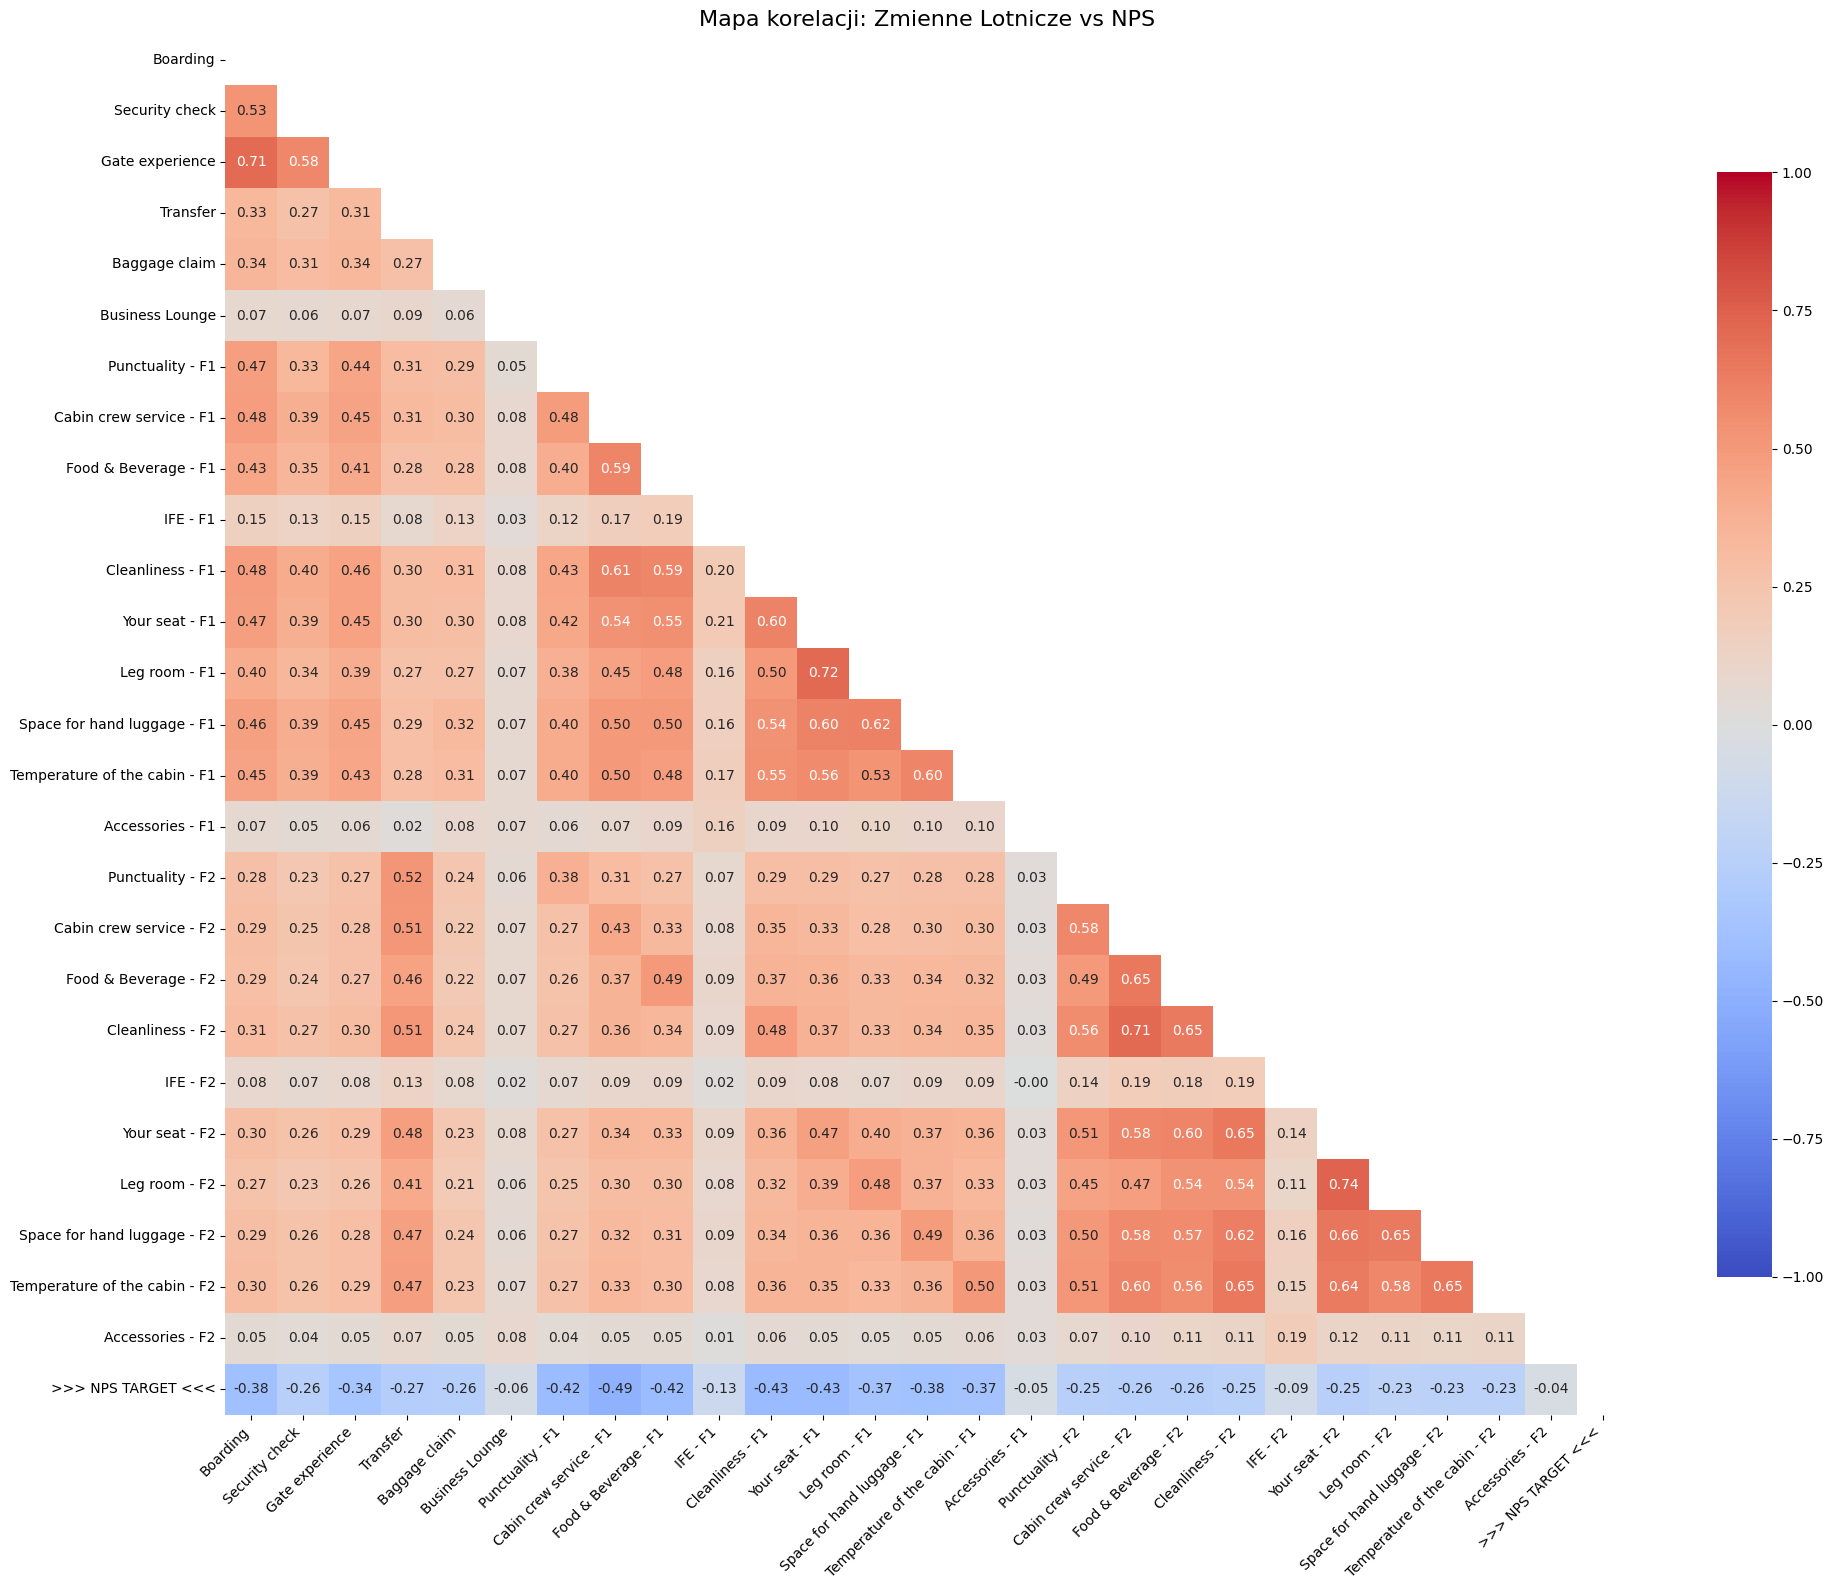

In [65]:
selected_columns = [
    'Boarding', 'Security check', 'Gate experience', 'Transfer', 
    'Baggage claim', 'Business Lounge',
    'Punctuality - F1', 'Cabin crew service - F1', 'Food & Beverage - F1', 
    'IFE - F1', 'Cleanliness - F1', 'Your seat - F1', 'Leg room - F1', 
    'Space for hand luggage - F1', 'Temperature of the cabin - F1', 'Accessories - F1',
    'Punctuality - F2', 'Cabin crew service - F2', 'Food & Beverage - F2', 
    'Cleanliness - F2', 'IFE - F2', 'Your seat - F2', 'Leg room - F2', 
    'Space for hand luggage - F2', 'Temperature of the cabin - F2', 'Accessories - F2'
]

df_analysis = X_train_final.copy()
# Dodaję NPS czyli zmienną celu
df_analysis = df_analysis[selected_columns]
df_analysis['>>> NPS TARGET <<<'] = y_train
# encoder zakodował -999 jako 0 dla wybranych kolumn kategorialnych, umieszczam je tu
f2_cols_with_zero_as_missing = [
    'Cabin Class - F2', 'Delay - F2', 'Range - F2'
]

# Korelacja Spearmana
corr_matrix = df_analysis.corr(method='spearman')

plt.figure(figsize=(20, 16))
# Używamy maski, żeby pokazać tylko dolny trójkąt
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask,
            cmap='coolwarm', 
            annot=True,     # w liczbowe
            fmt=".2f",      # 2 miejsca po przecinku
            vmin=-1, vmax=1, 
            cbar_kws={"shrink": .8})

plt.title("Mapa korelacji: Zmienne Lotnicze vs NPS", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [66]:
'''
----------1 obserwacja-------------
Zmienne o najniższej korelacji (Accessories, IFE, Business Lounge) charakteryzują się
najwyższym odsetkiem wartości -999 (brak usługi).

Obserwacja:
Niska korelacja wynika z braku wariancji – dla >90% pasażerów wartość jest stała
(imputowana średnia lub kod techniczny). "Rozcieńcza" to siłę związku liniowego.

Wnioski dla modelowania:
1. Sama wartość liczbowa (ocena) ma małe znaczenie globalne (dotyczy garstki ludzi).
2. Kluczowa informacja predykcyjna prawdopodobnie znajduje się w binarnej fladze
   (czy usługa była dostępna), a nie w samej ocenie.
3. Potwierdza to zasadność strategii: Neutralizacja Średnią + Flagi (Missing Indicators).

----------2 Obserwacja--------------
Relacja: Transfer -> Zmienne F2 (siła korelacji: 0.4 - 0.5)
   Diagnoza: "Efekt Bramki" (Zależność Strukturalna)
   - Mechanizm: Zmienna 'Transfer' jest warunkiem koniecznym istnienia zmiennych F2.
   - Interpretacja: Grupa bez transferu posiada wartości stałe (średnia/kod techniczny), 
     podczas gdy grupa z transferem posiada wartości zmienne. Algorytm korelacji 
     wykrywa ten schemat jako silny związek.
   - Wniosek: Potwierdza to logiczną spójność danych (brak ocen drugiego lotu u osób bez przesiadki).
---------3 obserwacja--------
Relacja: Cechy F1 <-> Cechy F2 (siła korelacji: 0.4 - 0.5)
   Diagnoza: "Spójność Produktu i Pasażera"
   - Czynnik Behawioralny: Pasażer posiada stałe cechy (np. wzrost, skłonność do krytyki), 
     które rzutują na ocenę obu lotów w ten sam sposób.
   - Wniosek: Jest to zdrowy poziom korelacji (wzmacnia sygnał, ale nie powoduje współliniowości)
'''

'\n----------Zjawisko 1-------------\nZmienne o najniższej korelacji (Accessories, IFE, Business Lounge) charakteryzują się\nnajwyższym odsetkiem wartości -999 (brak usługi).\n\nZjawisko:\nNiska korelacja wynika z braku wariancji – dla >90% pasażerów wartość jest stała\n(imputowana średnia lub kod techniczny). "Rozcieńcza" to siłę związku liniowego.\n\nWnioski dla modelowania:\n1. Sama wartość liczbowa (ocena) ma małe znaczenie globalne (dotyczy garstki ludzi).\n2. Kluczowa informacja predykcyjna prawdopodobnie znajduje się w binarnej fladze\n   (czy usługa była dostępna), a nie w samej ocenie.\n3. Potwierdza to zasadność strategii: Neutralizacja Średnią + Flagi (Missing Indicators).\n\n----------Zjawisko 2--------------\nRelacja: Transfer -> Zmienne F2 (siła korelacji: 0.4 - 0.5)\n   Diagnoza: "Efekt Bramki" (Zależność Strukturalna)\n   - Mechanizm: Zmienna \'Transfer\' jest warunkiem koniecznym istnienia zmiennych F2.\n   - Interpretacja: Grupa bez transferu posiada wartości stałe (ś

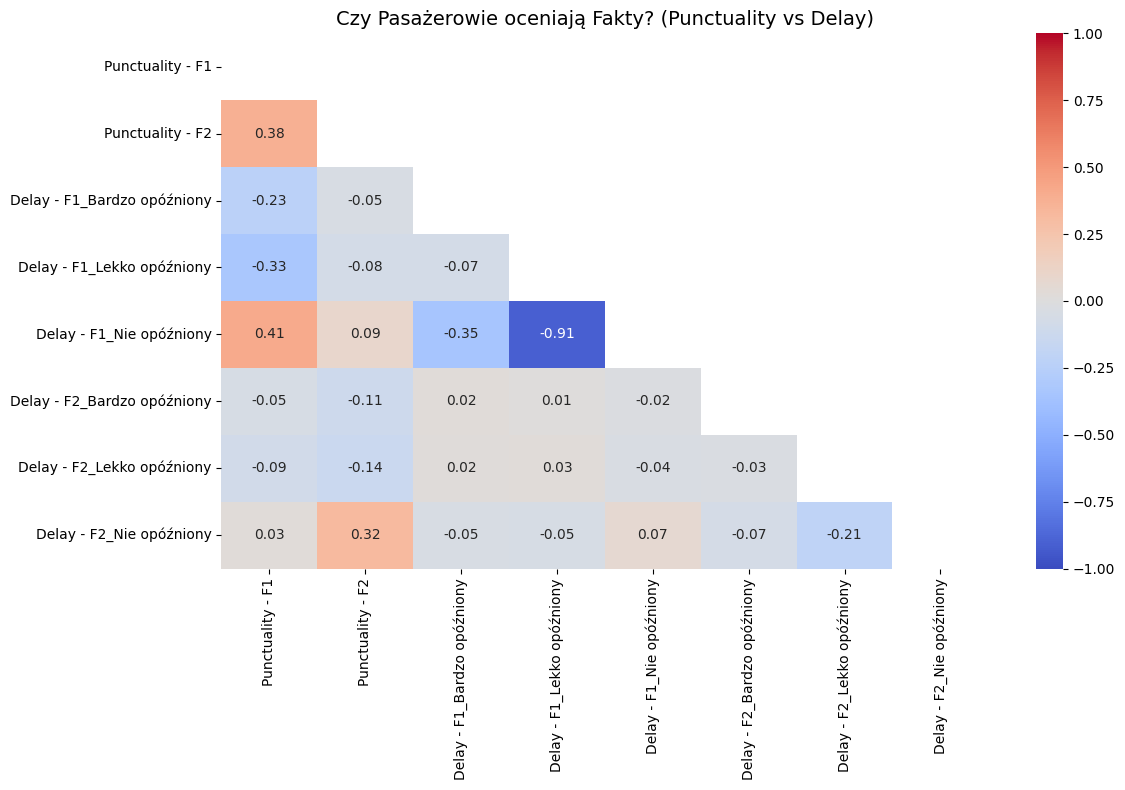

In [67]:
#Sprawdzam czy zmienna punctality jest silnie skorelowana z dummies mówiącymi o prawdziwym opóźnieniu samolotu
# Szukamy wszystkiego co ma w nazwie "Punctuality" LUB "Delay"
focus_cols = [col for col in X_train_final.columns if 'Punctuality' in col or 'Delay' in col]

# 2. Tworzymy mniejszą macierz korelacji
subset_corr = X_train_final[focus_cols].corr(method='spearman')
mask = np.triu(np.ones_like(subset_corr, dtype=bool))
# 3. Rysujemy czytelną heatmapę
plt.figure(figsize=(12, 8))
sns.heatmap(subset_corr,
            mask=mask,
            annot=True,       # Pokaż liczby
            cmap='coolwarm',  # Kolory: Czerwony (mocna dodatnia), Niebieski (mocna ujemna)
            fmt=".2f", 
            vmin=-1, vmax=1)  # Pełna skala od -1 do 1

plt.title("Czy Pasażerowie oceniają Fakty? (Punctuality vs Delay)", fontsize=14)
plt.tight_layout()
plt.show()
#Poniższa heatmapa wyjaśjnia że delay i punctuality nie są ze sobą silnie skorelowane, co może być trochę nielogiczne, ale 
# pasażerowie nie oceniają punktualności "z automatu" na podstawie zegarka. tutaj role gra też dobra komunikacja oraz obsługa tych nieregularności.
# W drugą strone samolot na przykłąd abrdzo długo kołował co technicznie opóźnieniem nie jest a pax uznał że punktualność słaba
# lekkie opóźnienia mają niższy współczynnik niż duże - to wynika z nierównowagi klas. Tych drugich jest poprostu znacznie mniej

In [68]:
### Eliminacja zmiennych skorelowanych (r > 0.7)
# Z pary skorelowanych zmiennych usuwamy tę, która ma słabszą korelację ze zmienną celu (NPS).

cols_to_drop = [

    'Gate experience',
    # Uzasadnienie: Silna korelacja z 'Boarding' (r=0.71).
    # 'Boarding' (wejście na pokład) jest pojęciem szerszym, obejmującym doświadczenie
    # przy bramce, i wykazuje silniejszy związek z NPS.

    'Leg room - F1',
    # Uzasadnienie: Silna korelacja z 'Your seat - F1' (r=0.72).
    # Zmienna 'Your seat' (ogólny komfort fotela) zawiera w sobie ocenę miejsca na nogi.
    # Pozostawienie obu wprowadzałoby szum informacyjny. Wybieramy silniejszy predyktor ('Your seat').

    'Leg room - F2',
    # Uzasadnienie: Analogicznie do F1. Bardzo wysoka korelacja (r=0.74) z 'Your seat - F2'.

    'Cleanliness - F1',

    'Cleanliness - F2'
    # Para 'Cleanliness' vs 'Cabin crew service' (r=0.71)
]

# Para 'Cleanliness' vs 'Cabin crew service' (r=0.71) została celowo pozostawiona
# Mimo korelacji (czystość wpływa na postrzeganie obsługi), są to
# rozłączne domeny operacyjne, które biznes może chcieć optymalizować niezależnie

# usuwam z każdego zbioru
X_train_final = X_train_final.drop(columns=cols_to_drop, errors='ignore')
X_val_final = X_val_final.drop(columns=cols_to_drop, errors='ignore')
X_test_final = X_test_final.drop(columns=cols_to_drop, errors='ignore')

## 1.8 Eksport gotowych zbiorów

In [ ]:
output_dir = '../Data/NPS_final'

print("Zapisywanie przetworzonych zbiorów do plików CSV...")

# Lista par: (zmienna, nazwa_pliku)
datasets = [
    (X_train_final, 'X_train_final.csv'),
    (X_val_final, 'X_val_final.csv'),
    (X_test_final, 'X_test_final.csv'),
    (y_train, 'y_train.csv'),
    (y_val, 'y_val.csv'),
    (y_test, 'y_test.csv')
]

for data, filename in datasets:
    path = os.path.join(output_dir, filename)
    # index=True musi byc zachowany index aby potem polaczyc z wynikami sentymentu
    data.to_csv(path, index=True) 
    print(f"Zapisano: {path}")

print("Zakończono eksport danych.")